<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fbase-models/models/base_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path
import shutil
import time
import psutil

# Regenerar el código con las condiciones específicas
notebook_globals = {
    "USE_CROSS_VALIDATION": False,
    "ENABLED_MODELS": ['CNN', 'GRU'],
    "ENABLED_EXPERIMENTS": ['time+cycles', 'all_features']
}

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/models' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
data_output_dir = BASE_PATH / 'data' / 'output'
model_output_dir = BASE_PATH / 'models' / 'output'


Mounted at /content/drive
Cloning into 'ml_precipitation_prediction'...
remote: Enumerating objects: 944, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 944 (delta 49), reused 6 (delta 6), pack-reused 863 (from 1)
Receiving objects: 100% (944/944), 102.63 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (517/517), done.
/content/ml_precipitation_prediction
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Reshape
import traceback

# ==== Variables de control ====
USE_CROSS_VALIDATION = False
ENABLED_MODELS = ['LSTM']
ENABLED_EXPERIMENTS = ['time+cycles+lag'] # 'time+cycles', 'time+cycles+elev', 'time+cycles+elev+cluster'
INPUT_WINDOW = 60
OUTPUT_HORIZON = 3

# ==== Funciones auxiliares ====
def build_model(model_type, input_shape, output_neurons, n_cells):
    model = Sequential()
    model.add(Input(shape=input_shape, dtype='float32'))  # ahora input_shape=(INPUT_WINDOW, n_cells*feats)
    if model_type == 'LSTM':
        model.add(LSTM(64))
    elif model_type == 'GRU':
        model.add(GRU(64))
    elif model_type == 'BLSTM':
        model.add(Bidirectional(LSTM(64)))
    # salida: OUTPUT_HORIZON pasos × n_cells celdas
    model.add(Dense(output_neurons * n_cells))
    model.add(Reshape((output_neurons, n_cells)))
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

# ==== Directorios y Dataset ====
model_output_dir_STH = Path("/content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack")
curves_dir = model_output_dir_STH / "learning_curves"
data_output_dir = Path("/content/drive/MyDrive/ml_precipitation_prediction/data/output")
file_path = data_output_dir / "complete_dataset_with_features_with_clusters_elevation_with_windows.nc"
model_output_dir_STH.mkdir(parents=True, exist_ok=True)
curves_dir.mkdir(parents=True, exist_ok=True)

print(f"✔️ Dataset cargado desde: {file_path}")
ds = xr.open_dataset(file_path)

# ==== Configuración de experimentos ====
experiment_settings = {
    "time+cycles": ['year','month',
                    'month_sin','month_cos','doy_sin','doy_cos'],
    "time+cycles+lag":  ['year','month',
                        'month_sin','month_cos','doy_sin','doy_cos',
                        'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                        'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36'],
    "time+cycles+lag+elev": ['year','month',
                             'month_sin','month_cos','doy_sin','doy_cos',
                            'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                            'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                            'elevation','slope','aspect'],
    "time+cycles+elev":   ['year','month',
                          'month_sin','month_cos','doy_sin','doy_cos',
                          'elevation','slope','aspect'],
    "time+cycles+elev+cluster":   ['year','month',
                                  'month_sin','month_cos','doy_sin','doy_cos',
                                  'elevation','slope','aspect',
                                  'cluster_elevation'],
    "all_features": ['year','month',
                     'month_sin','month_cos','doy_sin','doy_cos',
                    'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                    'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                    'elevation','slope','aspect',
                     'cluster_elevation']
}

results = []

for exp_name, variables in experiment_settings.items():
    if exp_name not in ENABLED_EXPERIMENTS:
        continue
    try:
        print(f"🔍 Procesando experimento: {exp_name}")
        # cargar y, si hay cluster, codificarlo
        subset = ds[variables].to_array().transpose('time','latitude','longitude','variable').values
        if 'cluster_elevation' in variables:
            idx = variables.index('cluster_elevation')
            flat = subset[..., idx].ravel()
            subset[..., idx] = LabelEncoder().fit_transform(flat).reshape(subset[..., idx].shape)
        subset = subset.astype(np.float32)
        target = ds['total_precipitation'].values

        samples, lat, lon, feats = subset.shape
        n_cells = lat * lon

        # [time, lat*lon, feats]
        X = subset.reshape(samples, n_cells, feats)
        y = target.reshape(samples, n_cells)

        # generar secuencias
        X_seq, Y_seq = [], []
        for i in range(samples - INPUT_WINDOW - OUTPUT_HORIZON):
            X_seq.append(X[i:i+INPUT_WINDOW])
            Y_seq.append(y[i+INPUT_WINDOW:i+INPUT_WINDOW+OUTPUT_HORIZON])
        X_seq = np.array(X_seq)   # (N, INPUT_WINDOW, n_cells, feats)
        Y_seq = np.array(Y_seq)   # (N, OUTPUT_HORIZON, n_cells)

        # *** Esta es la corrección clave: aplanar la dimensión de "feats" dentro de features ***
        N = X_seq.shape[0]
        X_seq = X_seq.reshape(N, INPUT_WINDOW, n_cells * feats)  # (N, INPUT_WINDOW, n_cells*feats)

        # filtrar secuencias con NaNs
        mask_X = ~np.isnan(X_seq).any(axis=(1,2))  # (N,)
        mask_Y = ~np.isnan(Y_seq).any(axis=(1,2))  # (N,)
        valid_mask = mask_X & mask_Y
        X_seq = X_seq[valid_mask]
        Y_seq = Y_seq[valid_mask]
        if len(X_seq)==0:
            print("⚠️ No quedan secuencias válidas tras filtrar NaNs.")
            continue

        # entrenar por modelo
        input_shape = (INPUT_WINDOW, n_cells * feats)
        split = int(len(X_seq)*0.7)
        X_tr, X_va = X_seq[:split], X_seq[split:]
        y_tr, y_va = Y_seq[:split], Y_seq[split:]

        # escalado
        scalerX = StandardScaler()
        X_tr = scalerX.fit_transform(X_tr.reshape(-1, input_shape[-1])).reshape(X_tr.shape)
        X_va = scalerX.transform  (X_va.reshape(-1, input_shape[-1])).reshape(X_va.shape)

        scalerY = StandardScaler()
        y_tr = scalerY.fit_transform(y_tr.reshape(-1,1)).reshape(y_tr.shape)
        y_va = scalerY.transform  (y_va.reshape(-1,1)).reshape(y_va.shape)

        for model_name in ENABLED_MODELS:
            model_path = model_output_dir_STH / f"{exp_name.replace('+','_')}_{model_name}_NoCV.h5"
            if model_path.exists():
                print(f"⏩ Ya existe: {model_path.name}")
                continue

            model = build_model(model_name, input_shape, OUTPUT_HORIZON, n_cells)
            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=100, batch_size=16, verbose=1,
                callbacks=[es]
            )

            y_pred = model.predict(X_va)
            # revertir escala
            y_pred = scalerY.inverse_transform(y_pred.reshape(-1,1)).reshape(y_pred.shape)
            y_true = scalerY.inverse_transform(y_va.reshape(-1,1)).reshape(y_va.shape)

            # evaluar
            metrics = [
                evaluate(y_true[:,i].ravel(), y_pred[:,i].ravel())
                for i in range(OUTPUT_HORIZON)
            ]
            results.append({
                'experiment': exp_name,
                'model': model_name,
                'horizon': OUTPUT_HORIZON,
                'RMSE': np.mean([m[0] for m in metrics]),
                'MAE':  np.mean([m[1] for m in metrics]),
                'MAPE': np.mean([m[2] for m in metrics]),
                'R2':   np.mean([m[3] for m in metrics]),
                'epochs': len(history.history['loss'])
            })

            # guardar curva
            plt.figure()
            plt.plot(history.history['loss'], label='Train')
            plt.plot(history.history['val_loss'], label='Val')
            plt.title(f"{exp_name} - {model_name}")
            plt.legend()
            plt.savefig(curves_dir / f"{exp_name.replace('+','_')}_{model_name}_NoCV.png")
            plt.close()

            model.save(model_path)
            print(f"✅ Guardado: {model_path.name}")

    except Exception as e:
        print(f"❌ Error en '{exp_name}': {e}\n{traceback.format_exc()}")

# resultados
results_df = pd.DataFrame(results)
results_df.to_csv("resultados_modelos_cv_fullmap.csv", index=False)
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Resultados Modelos FullMap", dataframe=results_df)


✔️ Dataset cargado desde: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
🔍 Procesando experimento: time+cycles+lag
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - loss: 0.9242 - val_loss: 0.6121
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.5676 - val_loss: 0.4791
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.4035 - val_loss: 0.4381
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.3392 - val_loss: 0.4042
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.3084 - val_loss: 0.4096
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.2741 - val_loss: 0.3924
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.2518 - val_loss: 0.3606
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.2373 - val_loss: 0.3392
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.2317 - val_loss: 0.3435
Epoch 10/100
19

✅ Guardado: time_cycles_lag_LSTM_NoCV.h5
Resultados Modelos FullMap


📂 Cargando dataset y rellenando NaNs…

🔍 Evaluando modelo: time_cycles_LSTM_NoCV


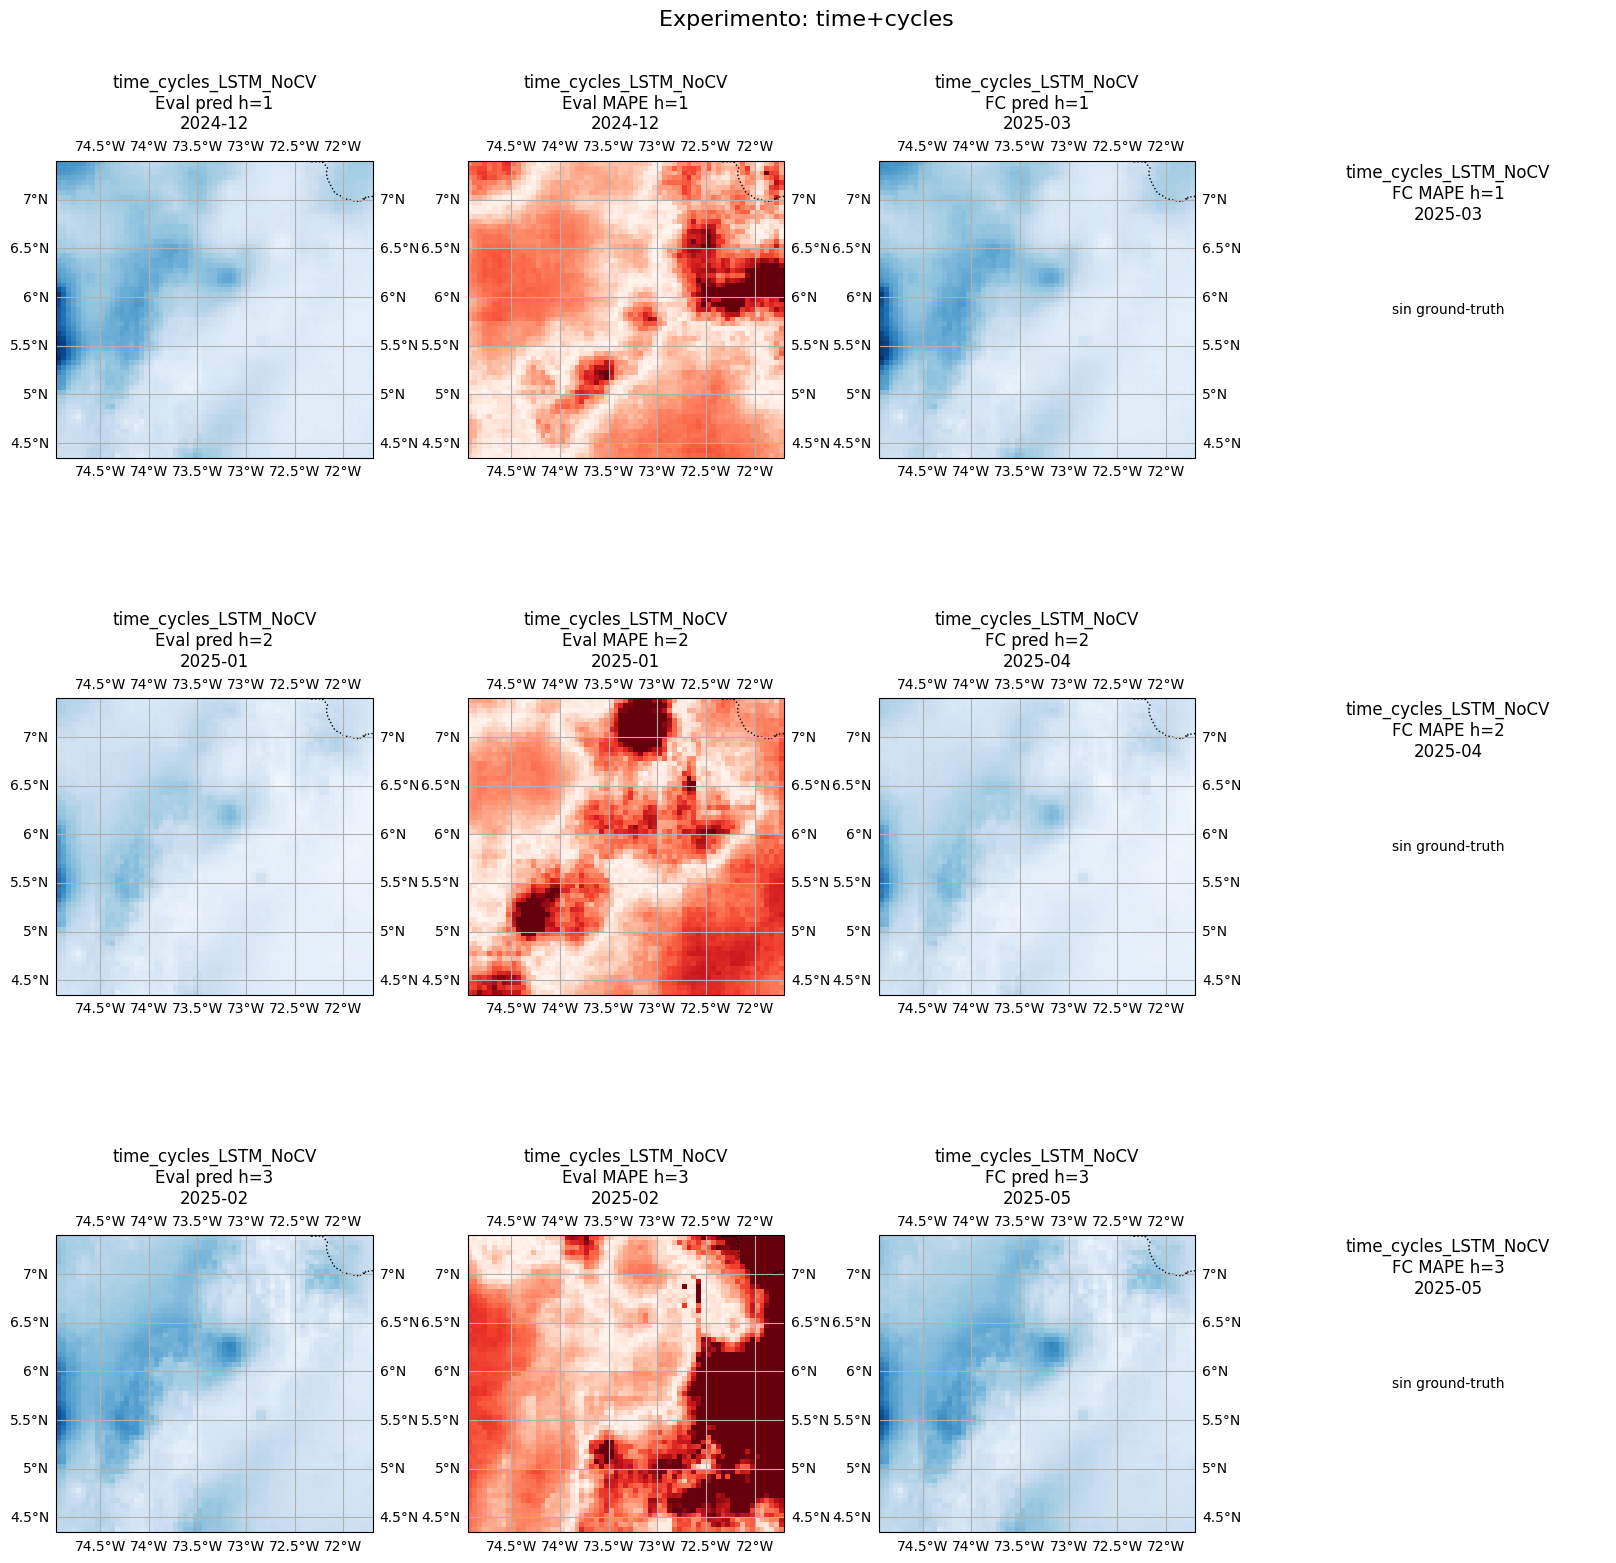

💾 GIF guardado en /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack/gifs/time_cycles_LSTM_NoCV_time+cycles_evol.gif

🔍 Evaluando modelo: time_cycles_elev_LSTM_NoCV


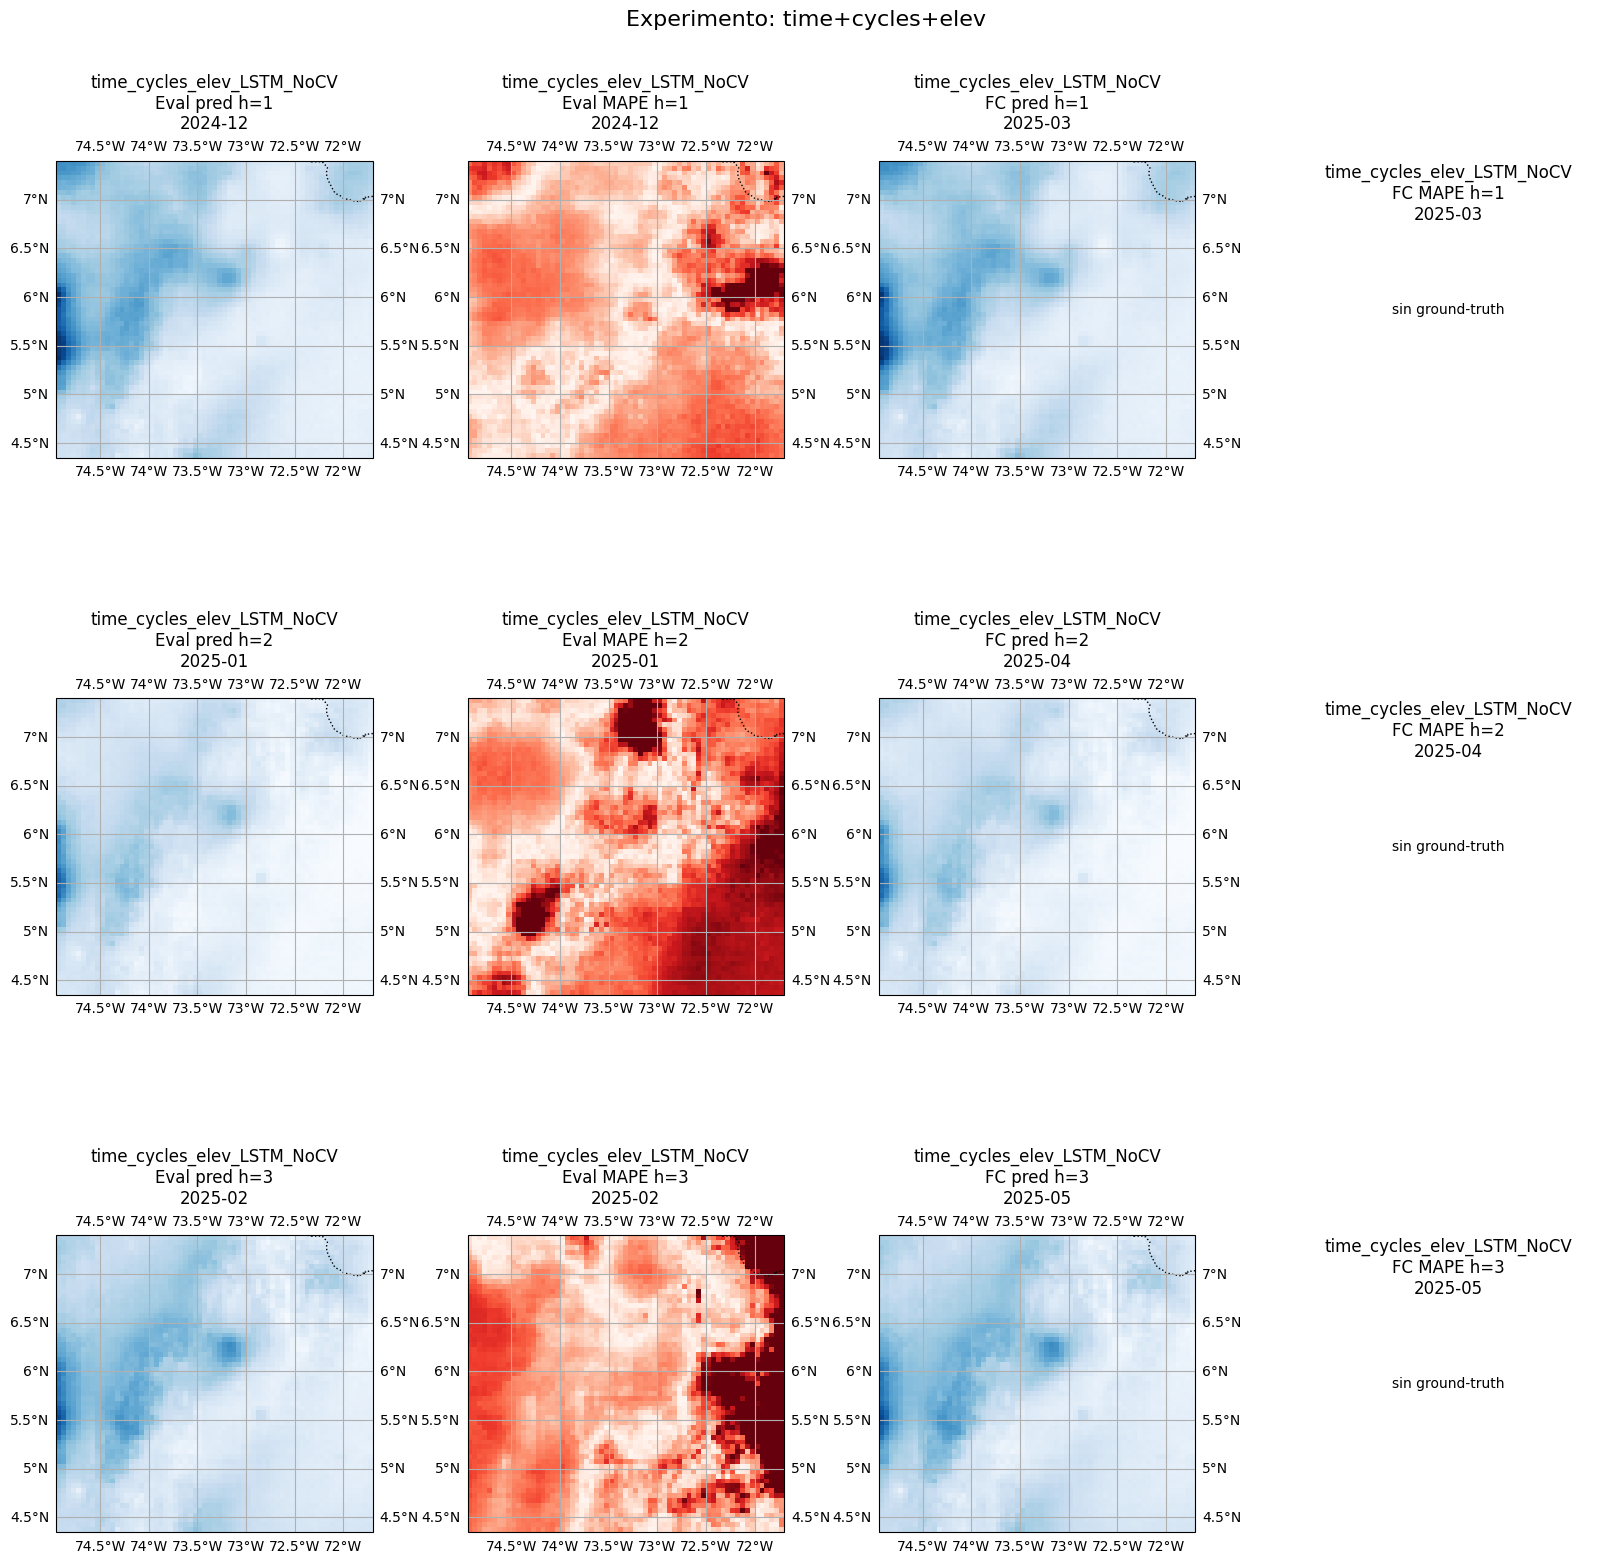

💾 GIF guardado en /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack/gifs/time_cycles_elev_LSTM_NoCV_time+cycles+elev_evol.gif

🔍 Evaluando modelo: time_cycles_elev_cluster_LSTM_NoCV


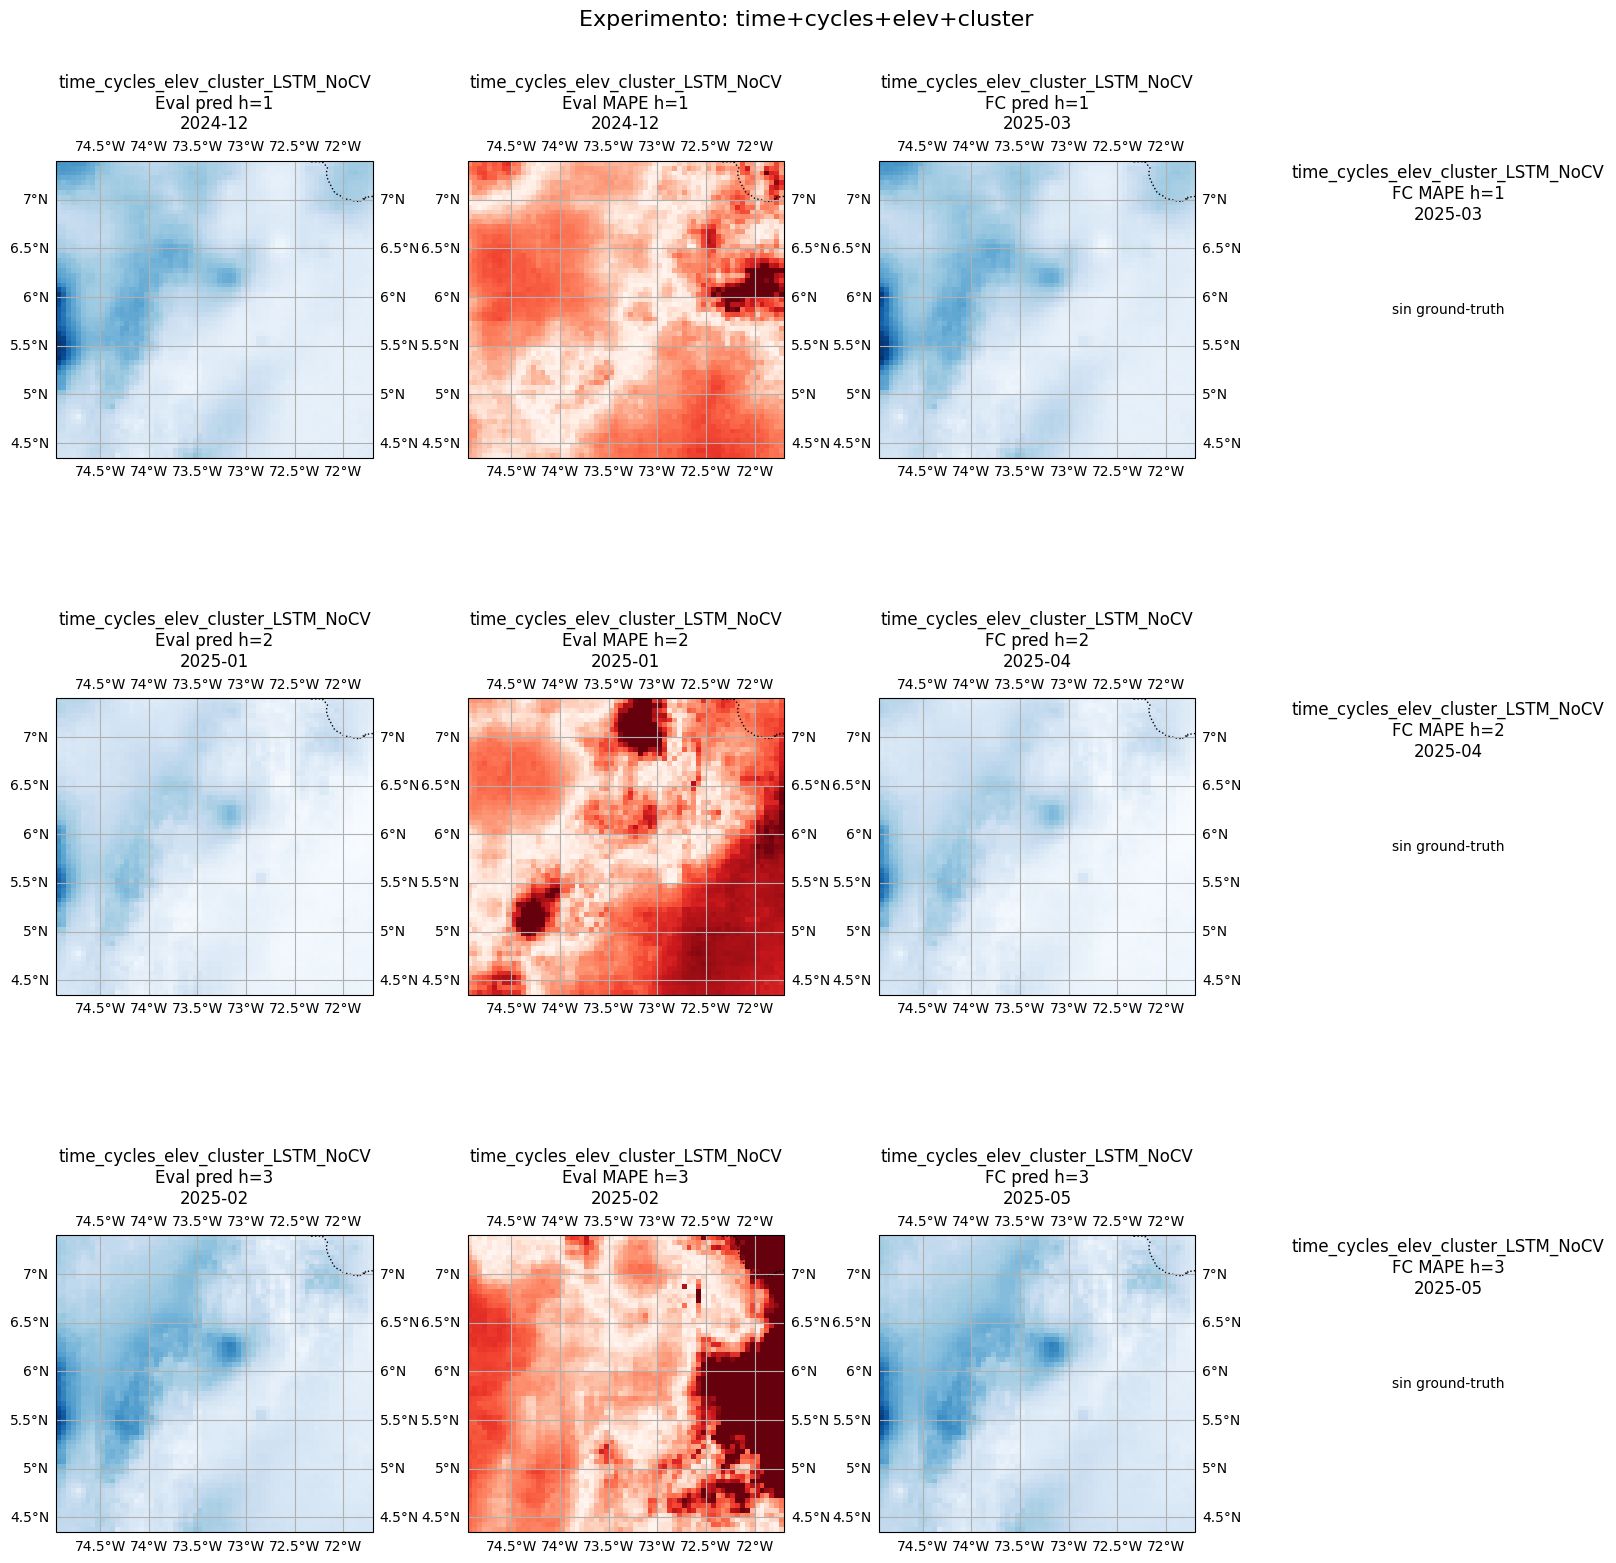

💾 GIF guardado en /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack/gifs/time_cycles_elev_cluster_LSTM_NoCV_time+cycles+elev+cluster_evol.gif

🔍 Evaluando modelo: time_cycles_lag_LSTM_NoCV


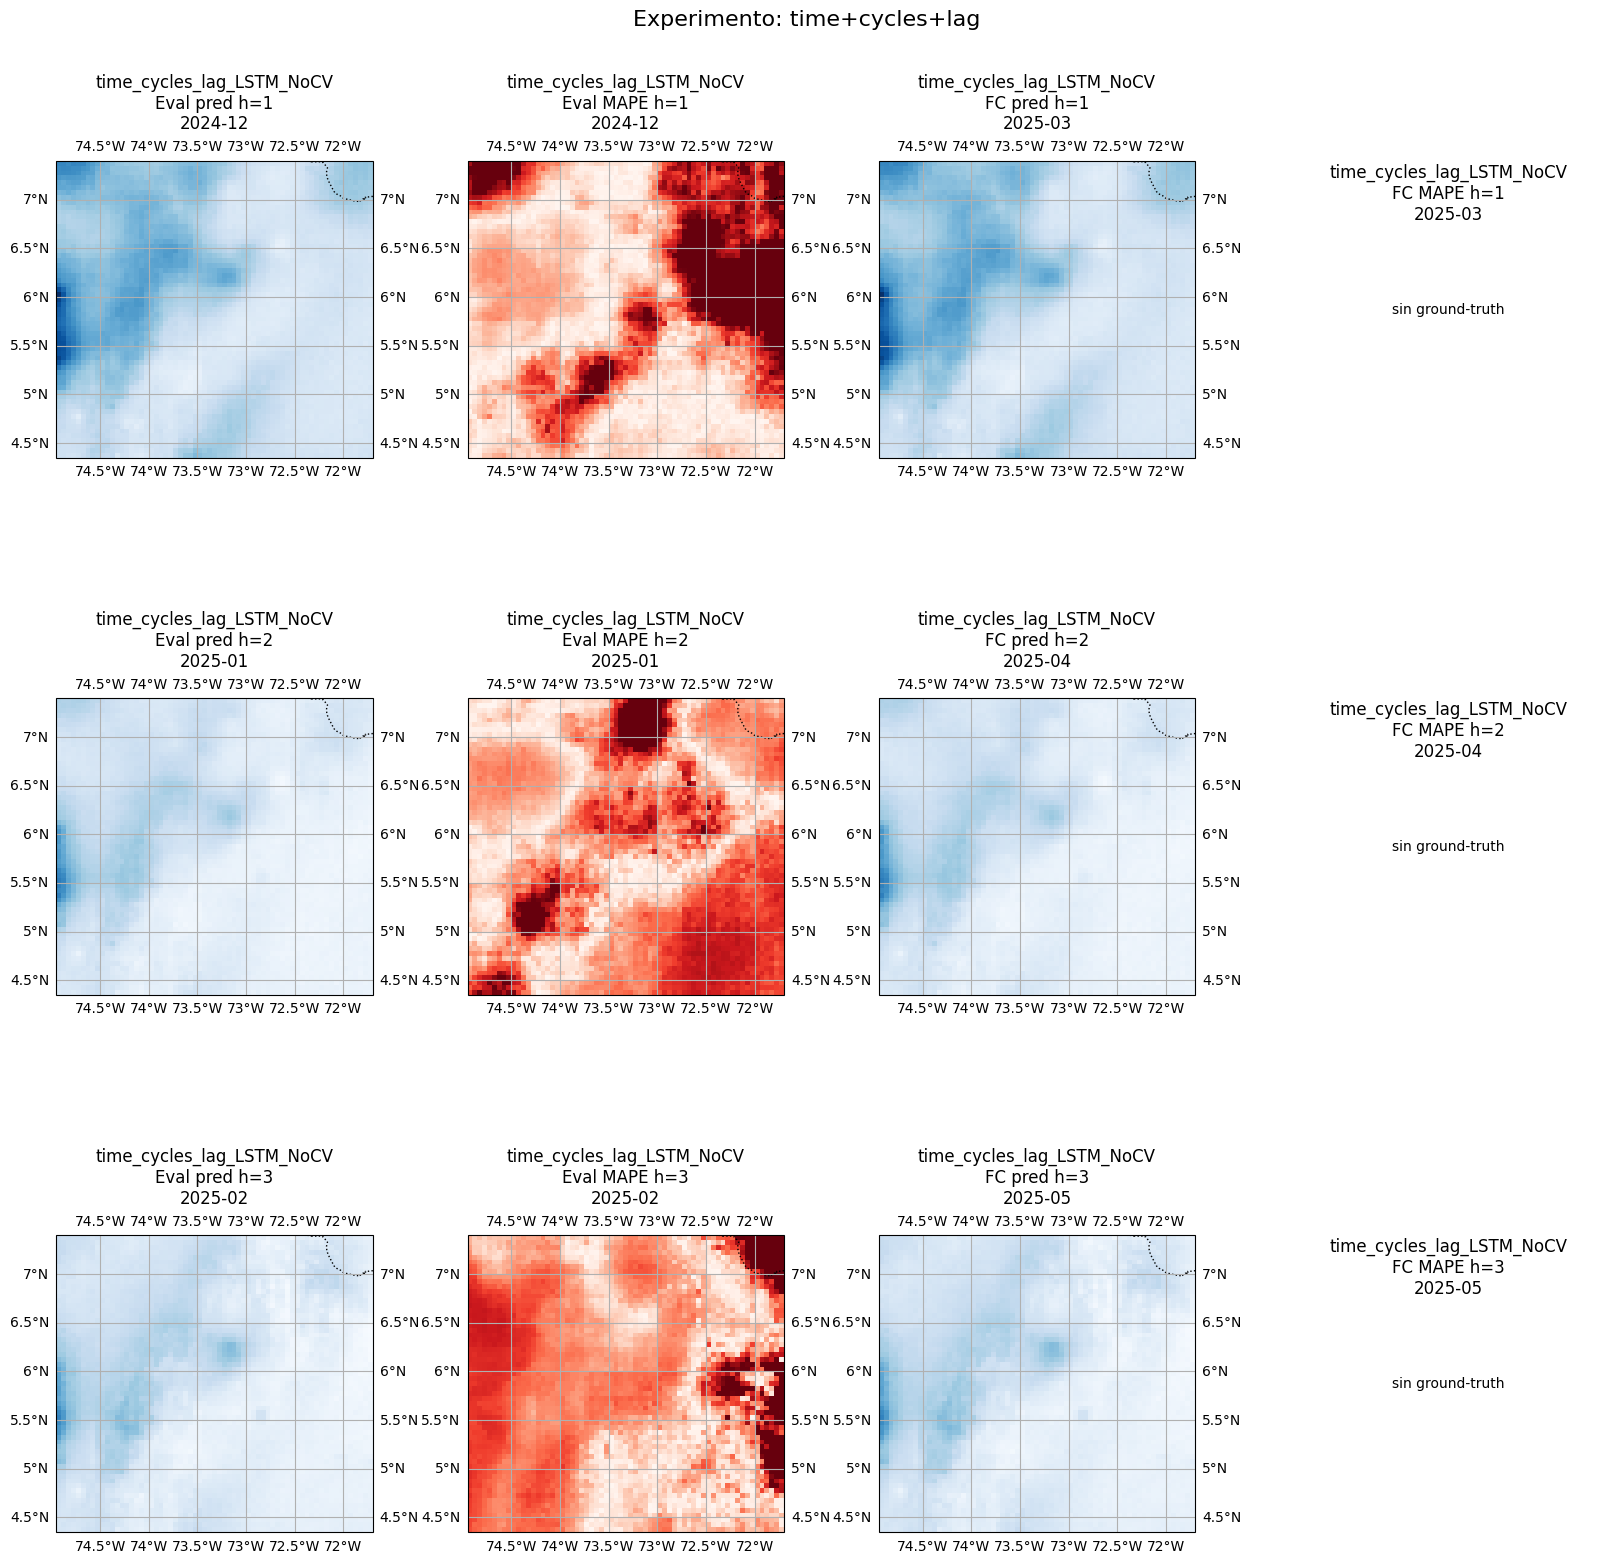

💾 GIF guardado en /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack/gifs/time_cycles_lag_LSTM_NoCV_time+cycles+lag_evol.gif

🔍 Evaluando modelo: time_cycles_lag_elev_cluster_LSTM_NoCV


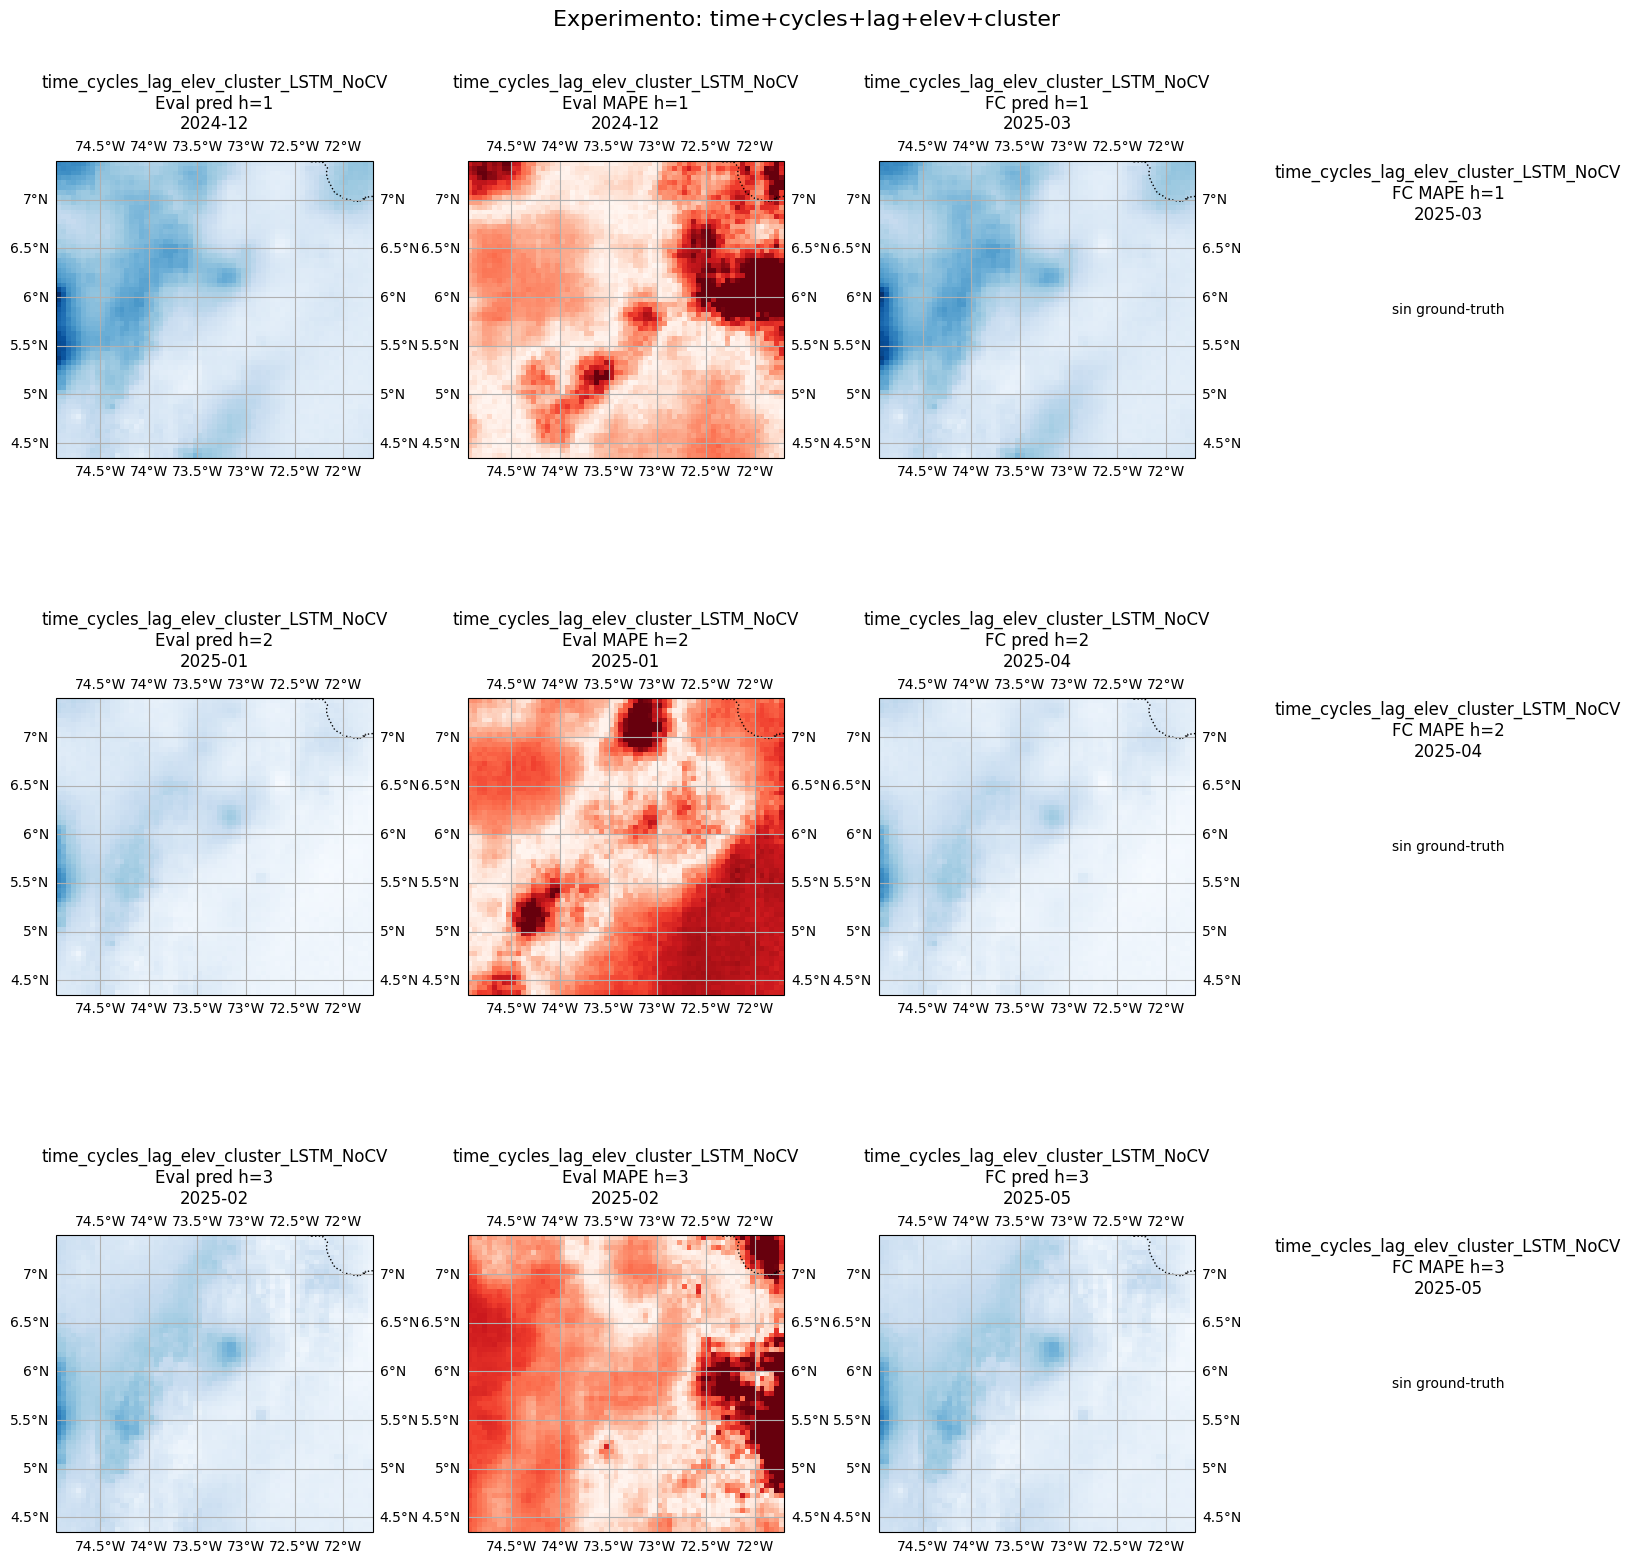

💾 GIF guardado en /content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack/gifs/time_cycles_lag_elev_cluster_LSTM_NoCV_time+cycles+lag+elev+cluster_evol.gif
Resultados Completo


✅ Proceso terminado exitosamente.


In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio.v2 as imageio  # usar v2 para evitar el DeprecationWarning
import traceback

# === CONFIGURACIÓN GENERAL ===
INPUT_WINDOW   = 60
HORIZON        = 3
TARGET_VAR     = 'total_precipitation'
BASE_MODEL_DIR = Path("/content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack")
DATASET_PATH   = Path("/content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc")
RESULTS_CSV    = BASE_MODEL_DIR / "metrics_modelos_test_completo.csv"
GIF_DIR        = BASE_MODEL_DIR / "gifs"
GIF_DIR.mkdir(exist_ok=True)

# === MAPEO DE EXPERIMENTOS A VARIABLES ===
experiment_settings = {
    "time+cycles":                   ['year','month','month_sin','month_cos','doy_sin','doy_cos'],
    "time+cycles+lag":               ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                       'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                                       'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36'],
    "time+cycles+elev":              ['year','month','month_sin','month_cos','doy_sin','doy_cos','elevation','slope','aspect'],
    "time+cycles+elev+cluster":      ['year','month','month_sin','month_cos','doy_sin','doy_cos','elevation','slope','aspect','cluster_elevation'],
    "time+cycles+lag+elev+cluster":  ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                       'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                                       'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                                       'elevation','slope','aspect','cluster_elevation'],
    "all_features":                  ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                       'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                                       'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                                       'elevation','slope','aspect','cluster_elevation']
}

# === CARGA DATASET ===
print("📂 Cargando dataset y rellenando NaNs…")
ds    = xr.open_dataset(DATASET_PATH).fillna(0)
times = pd.to_datetime(ds.time.values)
lat   = ds.latitude.size
lon   = ds.longitude.size
cells = lat * lon

# === PLOT UTIL ===
def quick_plot(ax, data, cmap, title, date_label, vmin=None, vmax=None):
    mesh = ax.pcolormesh(
        ds.longitude, ds.latitude, data,
        cmap=cmap, shading='nearest',
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS,   edgecolor='blue')
    ax.add_feature(cfeature.LAKES,    edgecolor='gray')
    # --- aquí añadimos la capa de límites de departamentos ---
    ax.add_feature(dept_boundaries, edgecolor='black', linewidth=0.5)
    # ---
    ax.gridlines(draw_labels=True)
    ax.set_title(f"{title}\n{date_label}", pad=8)
    return mesh

# ordenar para matching robusto
exp_keys = sorted(
    experiment_settings.keys(),
    key=lambda k: len(k.replace('+','_')),
    reverse=True
)

metrics = []

for model_path in sorted(BASE_MODEL_DIR.glob("*.h5")):
    model_name = model_path.stem
    print(f"\n🔍 Evaluando modelo: {model_name}")

    exp = next((k for k in exp_keys if k.replace('+','_') in model_name), None)
    if exp is None:
        print(f"⚠️ Experimento no reconocido para {model_name}.")
        continue

    try:
        vars_ = experiment_settings[exp]

        # extraer arrays y codificar cluster si aplica
        Xarr = ds[vars_].to_array().transpose("time","latitude","longitude","variable").values
        yarr = ds[TARGET_VAR].values
        if 'cluster_elevation' in vars_:
            idx = vars_.index('cluster_elevation')
            le  = LabelEncoder()
            flat = Xarr[...,idx].ravel()
            Xarr[...,idx] = le.fit_transform(flat).reshape(Xarr[...,idx].shape)

        T,_,_,feats = Xarr.shape
        if T < INPUT_WINDOW + HORIZON + 1:
            raise RuntimeError("No hay suficientes timestamps.")

        # reshape espacial
        Xfull = Xarr.reshape(T, cells, feats)
        yfull = yarr.reshape(T, cells)

        # ubica última ventana
        start      = T - INPUT_WINDOW - HORIZON
        end_window = start + INPUT_WINDOW
        end_targets= end_window + HORIZON

        X_eval = Xfull[start:end_window]       # (60, cells, feats)
        y_eval = yfull[end_window:end_targets] # (3,  cells)
        X_fc   = X_eval.copy()

        # fechas
        eval_dates = times[end_window:end_targets]
        fc_dates   = pd.date_range(
            times[-1] + pd.DateOffset(months=1),
            periods=HORIZON, freq="MS"
        )

        # escalado incremental (para manejo de memoria)
        sx = StandardScaler()
        sy = StandardScaler()
        for t in range(T):
            sx.partial_fit(Xfull[t])
            sy.partial_fit(yfull[t].reshape(-1,1))

        # escalar
        Xe = sx.transform(X_eval.reshape(-1, feats)).reshape(1, INPUT_WINDOW, cells, feats)
        Xf = sx.transform(X_fc.reshape(-1, feats)).reshape(1, INPUT_WINDOW, cells, feats)
        ye = sy.transform(y_eval.reshape(-1,1)).reshape(1, HORIZON, cells)

        # aplanar dims
        flat_dim = cells * feats
        Xe_m = Xe.reshape(1, INPUT_WINDOW, flat_dim)
        Xf_m = Xf.reshape(1, INPUT_WINDOW, flat_dim)

        # cargar modelo y chequeo
        model = tf.keras.models.load_model(model_path, compile=False)
        if model.input_shape[-1] != flat_dim:
            print(f"⚠️ Mismatch de input: modelo espera {model.input_shape[-1]}, flat_dim={flat_dim}")
            continue

        # predecir
        ye_hat_s = model.predict(Xe_m, verbose=0)
        yf_hat_s = model.predict(Xf_m, verbose=0)

        def to3(a):
            return a.reshape(1, HORIZON, flat_dim) if a.ndim==2 else a
        ye_hat_s = to3(ye_hat_s)
        yf_hat_s = to3(yf_hat_s)

        def inv(a3):
            flat = a3.reshape(-1,1)
            invf = sy.inverse_transform(flat).flatten()
            return invf.reshape(a3.shape)

        ye_hat = inv(ye_hat_s)[0]  # (HORIZON,cells)
        ye_true=  y_eval
        yf_hat = inv(yf_hat_s)[0]

        # figura por experimento
        fig, axes = plt.subplots(
            HORIZON, 4,
            figsize=(20,6*HORIZON),
            subplot_kw={'projection':ccrs.PlateCarree()}
        )
        # 1) ajustar márgenes para no pisar títulos
        fig.suptitle(f"Experimento: {exp}", fontsize=16, y=0.98)
        fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

        # calcular escala única para los GIF frames de predicción
        all_preds = np.stack([ye_hat[h].reshape(lat,lon) for h in range(HORIZON)], axis=0)
        pcm_min, pcm_max = 0, all_preds.max()

        gif_frames = []
        for h in range(HORIZON):
            tmap = ye_true[h].reshape(lat,lon)
            pmap = ye_hat[h].reshape(lat,lon)
            mape = np.clip(np.abs((tmap-pmap)/(tmap+1e-5))*100,0,100)
            fc   = yf_hat[h].reshape(lat,lon)

            quick_plot(
                axes[h,0], pmap, 'Blues',
                f"{model_name}\nEval pred h={h+1}", eval_dates[h].strftime("%Y-%m"),
                vmin=pcm_min, vmax=pcm_max
            )
            quick_plot(
                axes[h,1], mape, 'Reds',
                f"{model_name}\nEval MAPE h={h+1}", eval_dates[h].strftime("%Y-%m"),
                vmin=0, vmax=100
            )
            quick_plot(
                axes[h,2], fc, 'Blues',
                f"{model_name}\nFC pred h={h+1}", fc_dates[h].strftime("%Y-%m"),
                vmin=pcm_min, vmax=pcm_max
            )
            axes[h,3].axis('off')
            axes[h,3].text(
                0.5,0.5,"sin ground-truth",
                ha='center', va='center', transform=axes[h,3].transAxes
            )
            axes[h,3].set_title(
                f"{model_name}\nFC MAPE h={h+1}\n{fc_dates[h].strftime('%Y-%m')}",
                pad=8
            )

            # crear frame del GIF: sólo la predicción con colorbar externo
            fig2, ax2 = plt.subplots(
                1,1, figsize=(6,5),
                subplot_kw={'projection':ccrs.PlateCarree()}
            )
            mesh2 = ax2.pcolormesh(
                ds.longitude, ds.latitude, pmap,
                cmap='Blues', shading='nearest',
                vmin=pcm_min, vmax=pcm_max,
                transform=ccrs.PlateCarree()
            )
            ax2.coastlines()
            ax2.add_feature(cfeature.BORDERS, linestyle=':')
            ax2.gridlines(draw_labels=True)
            ax2.set_title(f"{model_name} — {exp}\n{eval_dates[h].strftime('%Y-%m')}", pad=8)
            cbar = fig2.colorbar(
                mesh2, ax=ax2, orientation='vertical',
                fraction=0.046, pad=0.04
            )
            cbar.set_label('Precipitación')
            plt.tight_layout()

            tmpfile = GIF_DIR / f"tmp_{model_name}_{exp}_h{h+1}.png"
            fig2.savefig(tmpfile, bbox_inches='tight')
            plt.close(fig2)
            gif_frames.append(imageio.imread(str(tmpfile)))

        plt.show()

        # guardar GIF con transición lenta (fps bajo = lento)
        gif_path = GIF_DIR / f"{model_name}_{exp}_evol.gif"
        imageio.mimsave(str(gif_path), gif_frames, fps=0.5)  # 0.5 cuadros/seg → 2s por frame
        print(f"💾 GIF guardado en {gif_path}")

        # métricas
        for h in range(HORIZON):
            t = ye_true[h]
            p = ye_hat[h]
            m_arr = np.clip(np.abs((t-p)/(t+1e-5))*100,0,100)
            metrics.append({
                'model':      model_name,
                'experiment': exp,
                'horizon':    h+1,
                'type':       'evaluation',
                'date':       eval_dates[h].strftime("%Y-%m"),
                'RMSE':       np.sqrt(mean_squared_error(t,p)),
                'MAE':        mean_absolute_error(t,p),
                'MAPE':       m_arr.mean(),
                'R2':         r2_score(t,p)
            })
            metrics.append({
                'model':      model_name,
                'experiment': exp,
                'horizon':    h+1,
                'type':       'forecast',
                'date':       fc_dates[h].strftime("%Y-%m"),
                'RMSE':       np.nan,
                'MAE':        np.nan,
                'MAPE':       np.nan,
                'R2':         np.nan
            })

    except Exception:
        print(f"❌ Error en {model_name}:\n{traceback.format_exc()}")

# guardar y mostrar tabla
df = pd.DataFrame(metrics)
df.to_csv(RESULTS_CSV, index=False)
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Resultados Completo", dataframe=df)

print("✅ Proceso terminado exitosamente.")
